# Stock Telemetry Field Mapping Project
______________________________
> **Note 1**: <span style="color:yellow">Assumptions</span> are given in text colored <span style="color:yellow">**Yellow**</span> and all the <span style="color:green">final conclusions (predictions)</span> are given by text colored <span style="color:green">**Green**</span>

This notebook explores the statistical and structural relationships between the columns to justify the inferred mapping.

This Jupyter notebook is designed to reverse-engineer and identify the actual financial field names from a given **time-series telemetry dataset** with anonymized column names. By leveraging **statistical analysis** and **financial domain knowledge**, we aim to accurately map each of the dummy fields to its corresponding financial concept, such as `Open`, `Close`, `High`, and more.

---

## 1. Glossary of Financial Terms

| Term                           | Description                                                                                   |
| ------------------------------ | --------------------------------------------------------------------------------------------- |
| **Open**                       | The price of a stock at the time of market opening (i.e., the starting price in the morning). |
| **Close**                      | The final traded price of a stock before the market closes for the day.                       |
| **Low**                        | The lowest price recorded for the stock on that trading day.                                  |
| **High**                       | The highest price reached by the stock during the trading day.                                |
| **Price**                      | The average price of the stock for the day                                                    |
| **Volume**                     | Total number of shares traded (bought/sold) during the observation period.                    |
| **Bull Market**                | Close > Open — price went up, positive sentiment.                                             |
| **Bear Market**                | Open > Close — price went down, negative sentiment.                                           |
| **Circuit Breaker/Price Band** | stops trading if a stock’s price changes too much too quickly, to keep the market calm.       |

---

## 2. Field Name Mapping Problem

### 2.1. Dummy Field Names (Given)

The dataset provides the following **anonymized telemetry variables**: `deltaX`, `gamma`, `omega`, `flux`, `pulse`, `neutronCount`   

### 2.2. Actual Field Names (To Be Predicted)

These are the **true financial field names** that need to be predicted: `Open`, `Close`, `Low`, `High`, `Price`, `Volume` 

---

## 3. Field Research & Assumptions

#### A.1 Volume Integrity

* **Volume** represents the number of shares traded and is inherently a **whole number**.

* While some brokerages (e.g., **Robinhood**, **Groww**) offer **fractional share trading**, such trades are typically **aggregated and executed in whole units** on traditional stock exchange. Hoever, major stock exchanges like the NYSE, NASDAQ, BSE, and NSE do not support fractional shares. Therefore, for the purposes of this project, we assume:

  > The dataset reflects data at the **exchange level**, where <span style="color:yellow">only **whole-number volumes** are allowed.</span>

##### References:

* [Fractional Shares: The Easy Way to Invest Fractionally in US Stocks from India](https://www.indmoney.com/blog/us-stocks/what-are-fractional-shares)
* [Volume of Trade: How it Works, What it Means, and Examples](https://www.investopedia.com/terms/v/volumeoftrade.asp)


#### A.2 Time Granularity (Per Day Trading Data Assumption)

* The dataset lacks explicit **timestamps** or **frequency annotations**.
* However, financial fields such as `Open`, `Close`, `High`, and `Low` are typically recorded at a **daily resolution** as we an see in Public APIs (e.g., Alpha Vantage, Yahoo Finance) and Regulatory filings and EOD reports. Thus, we assume:

  > <span style="color:yellow"> Each row in the dataset corresponds to **one trading day per stock**.</span>

##### References:

* [Investopedia – Open, High, Low, Close (OHLC)](https://www.investopedia.com/terms/o/ohlcchart.asp)
* [Alpha Vantage OHLC API Documentation](https://www.alphavantage.co/documentation/)

#### A.3 Trading Period (Duration Assumption)

* The number 252 is used as a standard for trading days in a year, accounting for weekends and holidays, to ensure consistency in financial calculations.

  > As per the standards we assume <span style="color:yellow"> 1 year = **252 days** and 1 month = **21 days**.</span>

##### References:

* [How Many Trading Days in a Year?](https://www.ultimamarkets.com/academy/how-many-trading-days-in-a-year/)

---


## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from matplotlib.patches import Rectangle

# Set seaborn style
sns.set_style(style="whitegrid")

## Constants

In [2]:
ORANGE       = '#D55E00'
BLUE         = '#0173B2'
GREEN        = '#029E73'
PINK         = '#CC78BC'
YELLOW       = '#F0E442'
RED          = '#EF5350'
colors       = [ORANGE, BLUE, PINK, GREEN, YELLOW]

DATASET_PATH = "sample_data_with_fabricated_columns.csv"
EPSILON      = 1e-6

## Reading Dataset

In [3]:
# Load data
df = pd.read_csv(DATASET_PATH)

all_columns = df.columns.tolist()

## Preprocessing

### Checking for zero, negative and null values in the columns

In [4]:
# Print negative, zero, and null value counts using PrettyTable
table = PrettyTable()
table.field_names = ["Column", "Negative Values", "Zero Values", "Null Values"]

cols_with_negatives = []
cols_with_zeros = []
null_vals_present = False

for col in df.columns:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        cols_with_negatives.append(col)

    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        cols_with_zeros.append(col)

    null_count = df[col].isnull().sum()
    if null_count > 0:
        null_vals_present = True
        
    table.add_row([col, negative_count, zero_count, null_count])

print("Negative, zero, and null value counts per column:")
print(table)

Negative, zero, and null value counts per column:
+--------------+-----------------+-------------+-------------+
|    Column    | Negative Values | Zero Values | Null Values |
+--------------+-----------------+-------------+-------------+
|    deltaX    |      78897      |      0      |      0      |
|    gamma     |      78792      |      0      |      0      |
|    omega     |      79008      |      0      |      0      |
|     flux     |      78909      |      0      |      0      |
|    pulse     |      78909      |      0      |      0      |
| neutronCount |        0        |      0      |      0      |
+--------------+-----------------+-------------+-------------+


#### A.4 Presence of Constant Systemic Error in API

<span style="color:orange">The data contains approximately **80K negative values** in each price-related column (<u>deltaX</u>, <u>gamma</u>, <u>omega</u>, <u>flux</u>, <u>pulse</u>). This is likely <span style="color:yellow">due to a **constant systematic error**</span> in the API. To correct this, we add the absolute of the **minimum value + $\epsilon$ ($10^{-6}$)** in each column to all its entries, ensuring all values are positive and non-zero.</span>


### Removing systematic error, Adding $\epsilon$ to 0 values & Removing null rows

In [5]:
# Remove rows with null values
if null_vals_present > 0:
    df = df.dropna()

global_min = df.min().min()

# Apply transformation to each price column
if len(cols_with_negatives) > 0:
    for col in cols_with_negatives:
        adjustment = abs(global_min) + EPSILON
        df[col] = df[col] + adjustment

# Replace zeros with epsilon in specified columns
if len(cols_with_zeros) > 0:
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, EPSILON)

# Create a summary table
table = PrettyTable()
table.field_names = ["Column", "Negative Values", "Zero Values", "Min Value"]

for col in df.columns:
    negative_count = (df[col] < 0).sum()
    zero_count = (df[col] == 0).sum()
    min_value = df[col].min()
    table.add_row([col, negative_count, zero_count, f"{min_value:.6f}"])

print("Final verification table:")
print(table)

Final verification table:
+--------------+-----------------+-------------+-------------+
|    Column    | Negative Values | Zero Values |  Min Value  |
+--------------+-----------------+-------------+-------------+
|    deltaX    |        0        |      0      |   0.154640  |
|    gamma     |        0        |      0      |   0.558683  |
|    omega     |        0        |      0      |   0.000001  |
|     flux     |        0        |      0      |   0.115293  |
|    pulse     |        0        |      0      |   0.382485  |
| neutronCount |        0        |      0      | 1000.000000 |
+--------------+-----------------+-------------+-------------+


## Descriptive Statistics

In [6]:
df.describe()

,deltaX,gamma,omega,flux,pulse,neutronCount
count,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000
mean,307.092241,307.284792,3.068995e+02,307.092452,307.092386,50541.730472
std,103.796442,103.796594,1.037972e+02,103.797320,103.796308,28578.459770
min,0.154640,0.558683,1.000000e-06,0.115293,0.382485,1000.000000
25%,251.327902,251.515180,2.511248e+02,251.321431,251.331950,25810.000000
50%,325.979502,326.168835,3.257893e+02,325.996891,325.975111,50604.000000
75%,387.316786,387.503924,3.871244e+02,387.307791,387.317123,75257.000000
max,498.588170,498.592219,4.983957e+02,498.432596,498.349623,99999.000000


#### Observations:

> 1. The statistics indicate that the column `neutronCount` has exceptionally high values as compared to other columns. 
>
> 2. Unlike the other columns, all of it's quartiles (1st, 2nd and 3rd) and min, max values are exact integers.
>
> 3. The rest of the fields (open, close, high, low and price) are all stock prices related to the particular day (from assumption) so their prices should be nearby each other, thus <i> we suspect neturonCount field to be the actual `volume` field.</i>

### Identifying Volume

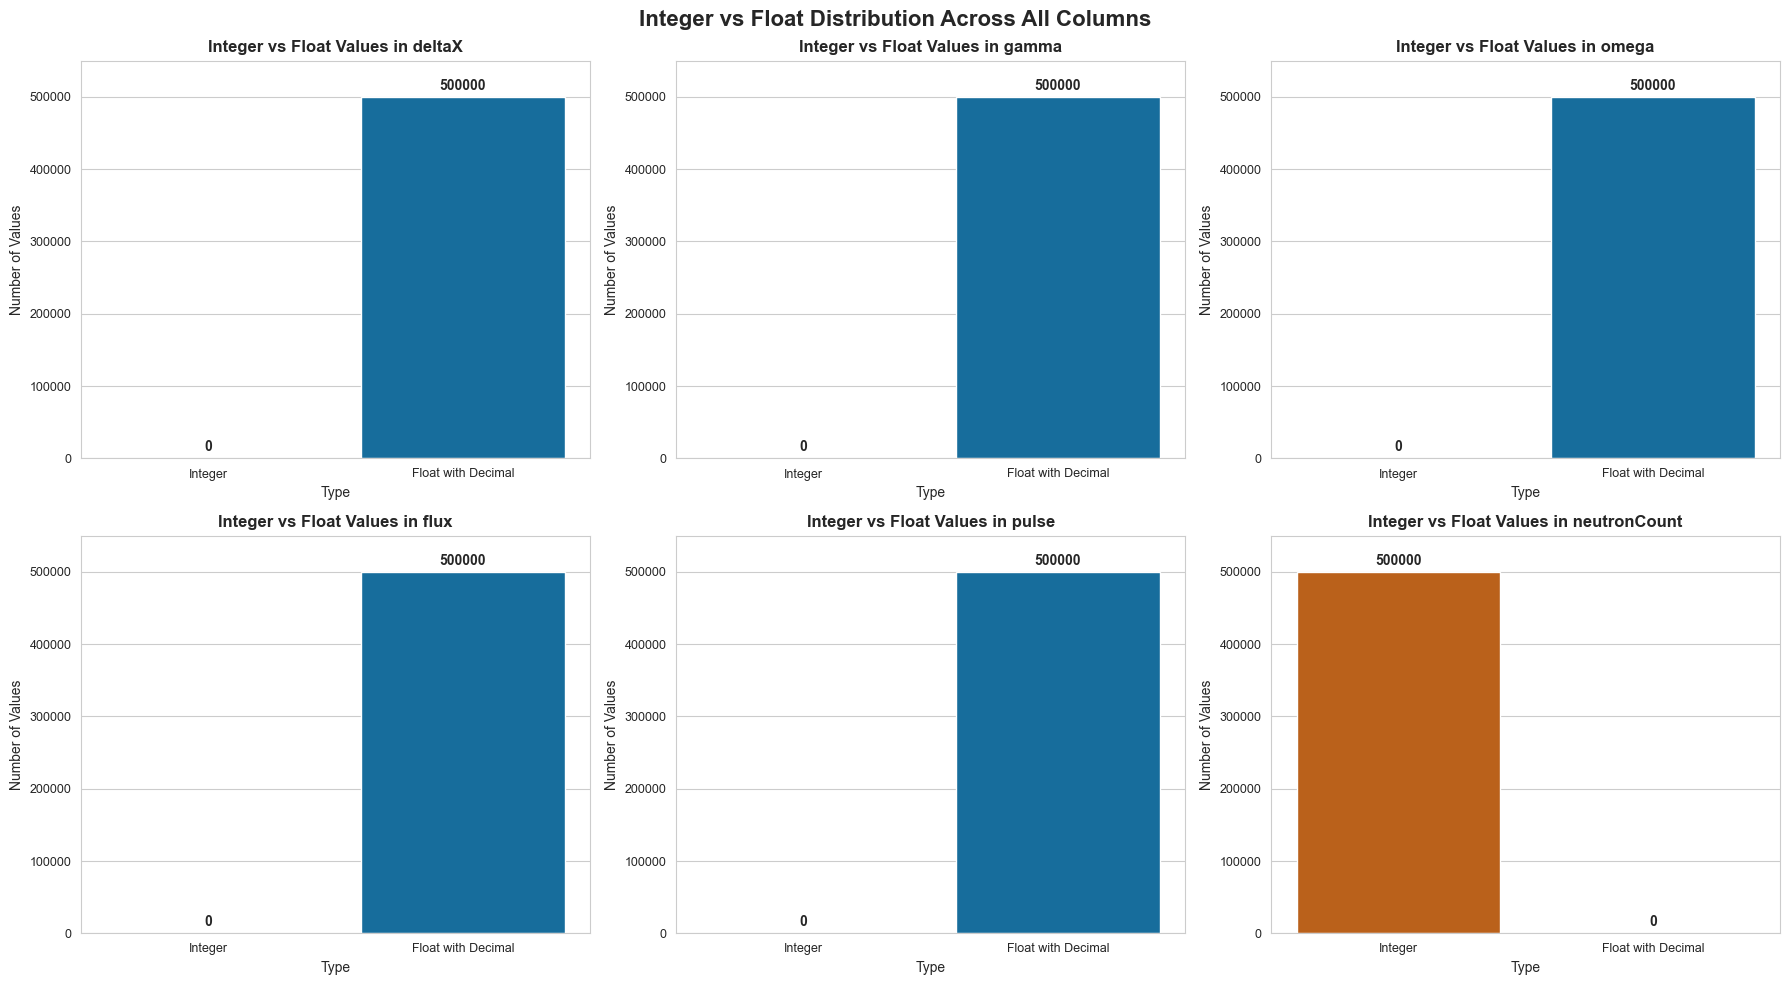

In [7]:
# Counts number of integer and float values in each column
def classify_values(series):
    int_count = sum(x == int(x) for x in series if pd.notnull(x))
    float_count = sum(x != int(x) for x in series if pd.notnull(x))
    return pd.DataFrame({
        'Type': ['Integer', 'Float with Decimal'],
        'Count': [int_count, float_count]
    })

# Calculate max value of y for consistent y-ranges across all plots
all_max_counts = []
column_data = {}
for col in all_columns:
    column_data[col] = classify_values(df[col])
    all_max_counts.append(column_data[col]['Count'].max())

y_max = max(all_max_counts) * 1.1 # Calculate y-range (max + 10%) for better readability

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(all_columns):
    value_counts_df = column_data[col]

    barplot = sns.barplot(
        data=value_counts_df,
        x="Type",
        y="Count",
        hue="Type",
        palette=colors[:2],
        legend=False,
        ax=axes[i]
    )
    
    axes[i].set_ylim(0, y_max) # y-ranges set to be consistent across all plots 
    
    # Write the count values on top of the bars
    for j, row in value_counts_df.iterrows():
        axes[i].text(j, row["Count"] + y_max*0.01, str(row["Count"]), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[i].set_title(f"Integer vs Float Values in {col}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Type", fontsize=10)
    axes[i].set_ylabel("Number of Values", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)

fig.suptitle('Integer vs Float Distribution Across All Columns', fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

#### Observations:
> 1. The descriptive statistics above shows very high values trend for the `neutronCount` column.
>
> 2. The plots above show that all values in the `neutronCount` column are integers, which is highly unlikely for a stock price to be. 

<span style="color:green"><b><i> Hence we predict `neutronCount` to be the `Volume` column. </b></i></span>

In [8]:
# Defining global variable for Volume and a dataset for only price-related columns (excluding volume)
VOLUME = 'neutronCount'
df_price_columns = df.drop(VOLUME, axis=1)
price_columns = df_price_columns.columns.tolist()

### Correlation Analysis

#### A.5 Values similar/nearby for open/close or high/low fields

> Now based on the our assumption of `Time Granularity` [A.2] - that open, close, high, low and price are all measures of a stock price <i>on a particular day</i> - the values of these quantities should vary in correlation with each other. 
>
> It is highly unlikely for a stock to drop a lot on a single day due to the implementation of "circuit breaker" or "price band". <span style="color:yellow">Assuming that this data is from such a stock market, so it is safe to assume that there won't be a lot of difference in all these measures of the stock for a day - hence assumption of <i>similar/nearby values for open/close or high/low fields</i></span>. To verify this we plot the correlation plots and pair plot to visualise the correlation trends in the rest of the 5 data columns.

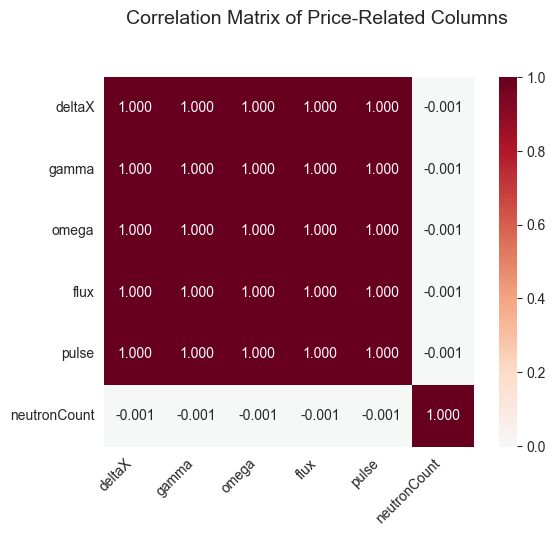

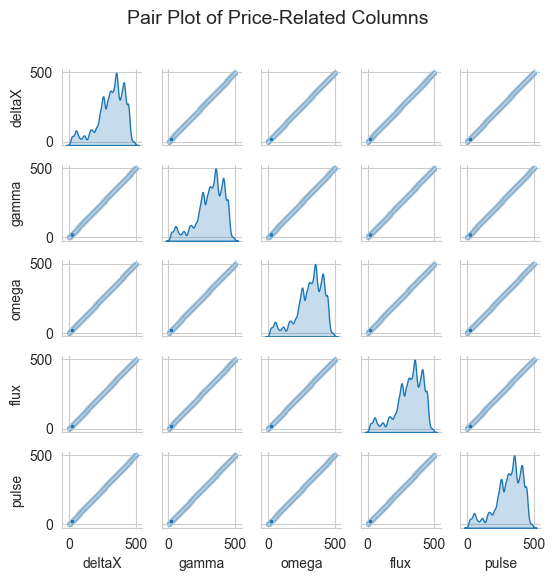

In [9]:
# Correlation heatmap
correlation_matrix = df.corr()
heatmap = sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.3f',
            )
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
heatmap.figure.suptitle('Correlation Matrix of Price-Related Columns', fontsize=14, y=1.02)
plt.show()

# Pair plot for only price-related columns (excluding neutronCount)
pair_plot = sns.pairplot(df_price_columns,
                         diag_kind='kde',
                         plot_kws={'alpha': 0.6, 's': 10},
                         diag_kws={'fill': True},
                         height=1.13,
                         aspect=1.0)
pair_plot.figure.suptitle('Pair Plot of Price-Related Columns', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#### Observations:

> 1. **Correlation Matrix Observation**: The correlation matrix reveals that five fields (`deltaX`, `gamma`, `omega`, `flux`, `pulse`) are nearly perfectly correlated with one another (correlation ≈ 1.0), indicating they capture the same underlying price trend. In contrast, `neutronCount` shows almost zero correlation with these fields, reinforcing the assumption that it represents a fundamentally different metric—most likely **Volume**.
>
> 2. **Pair Plot Observation**: The pair plot further confirms the strong linear relationships among the five price-related fields, as seen by the straight-line scatter patterns and nearly identical distribution curves along the diagonals. This visual consistency supports the idea that these columns are variations of the similar signal.

### Row-wise Statistics inference

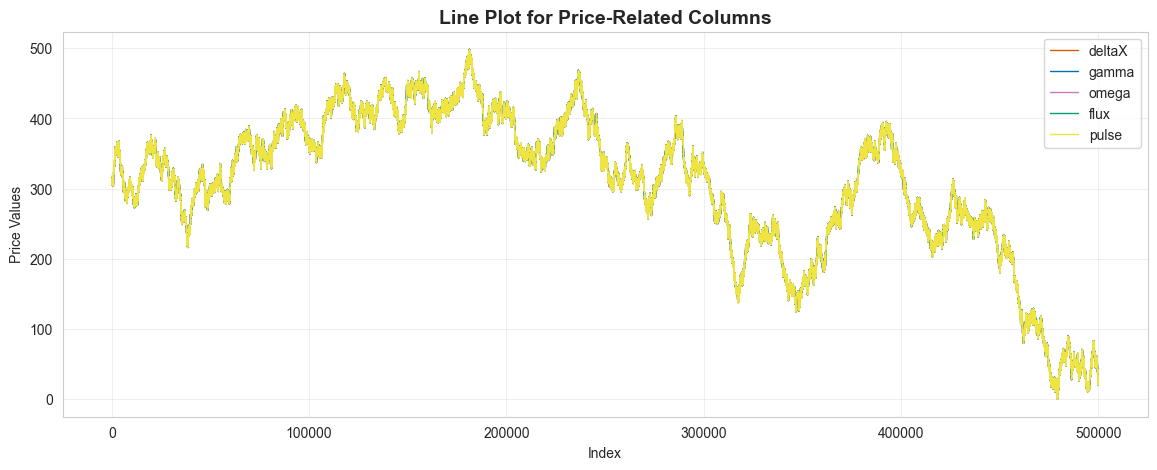

In [10]:
plt.figure(figsize=(14, 5))
for i, column in enumerate(price_columns):
    plt.plot(df.index, df[column], label=column, linewidth=1, color=colors[i])

plt.title('Line Plot for Price-Related Columns', fontsize=14, fontweight='bold')
plt.xlabel('Index')
plt.ylabel('Price Values')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()


#### Observations:
> The current line chart displays overlapping signals due to the large overall scale of both axes relative to the smaller variations between individual column values. As a result, differences among the series are visually obscured.
>
> To better distinguish the behavior of each column, we propose calculating a **mean signal** by averaging values across all columns for each row. This average can serve as a **baseline flow**.
>
> By subtracting this mean baseline from each individual column's value, we obtain a **deviation plot**, highlighting how each column deviates from the overall trend. This approach exaggerates the distinctions between columns and makes the individual dynamics more interpretable.

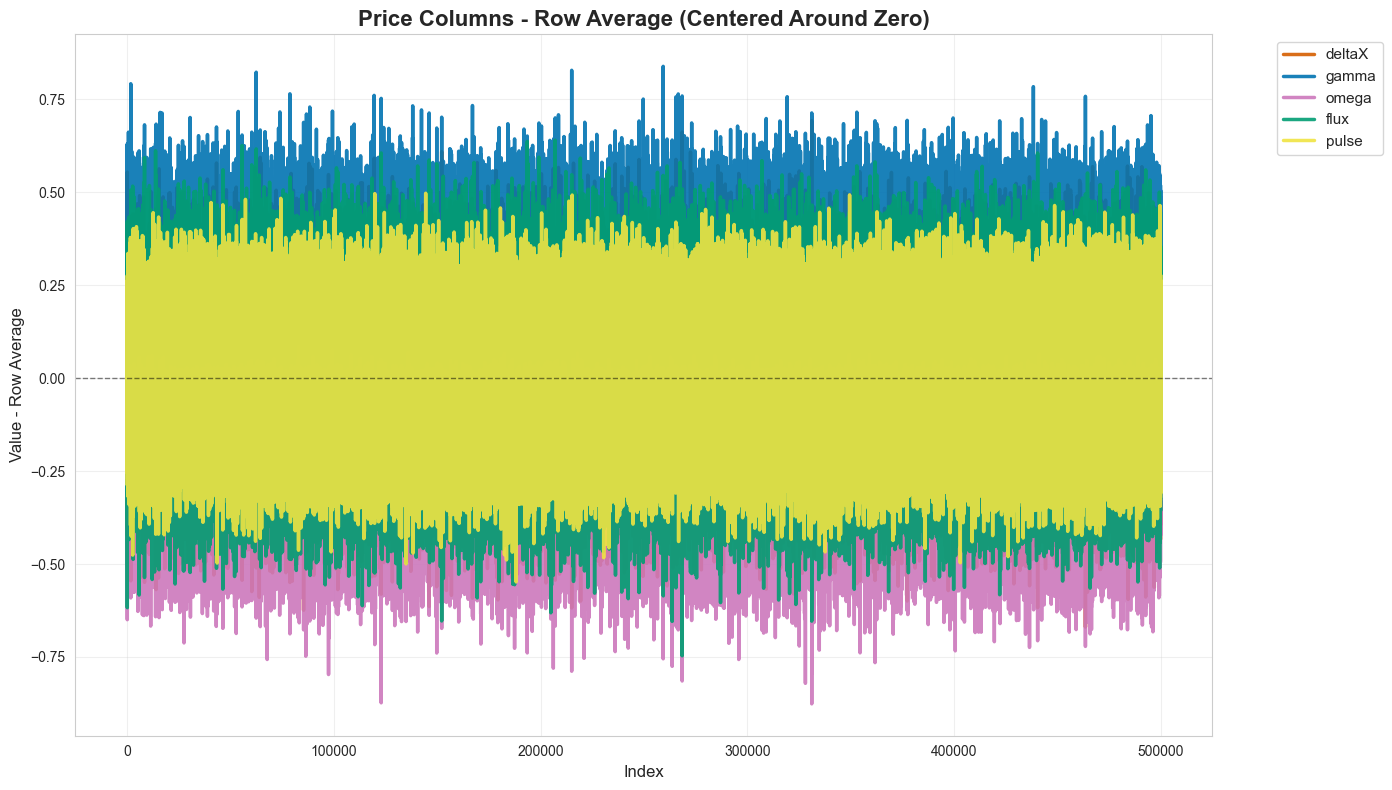

In [11]:
row_averages = df_price_columns.mean(axis=1)

# Create a new dataframe with each column value minus the row average (price columns only)
df_centered = df_price_columns.subtract(row_averages, axis=0)

# Plot all centered price columns with distinctive colors
plt.figure(figsize=(14, 8))

for i, column in enumerate(df_centered.columns):
    plt.plot(df_centered.index, df_centered[column], 
             label=column, linewidth=2.5, alpha=0.9, color=colors[i])

plt.title('Price Columns - Row Average (Centered Around Zero)', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value - Row Average', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.tight_layout()
plt.show()

#### Observations:
> In the deviation plot, it is evident that the column **`omega`** consistently occupies the **lowest band**, while **`gamma`** appears in the **uppermost band** across the timeline. Based on this observation, and by the nature of their relative positions, it is reasonable to hypothesize that `omega` corresponds to the **Low** price and `gamma` to the **High** price.
>
> To validate this assumption and to better visualize the individual patterns without overlap, we present a set of aligned subplots below, each showing the deviation of one column separately. This separation allows for a clearer comparison of the value distributions and their respective behaviors over time.

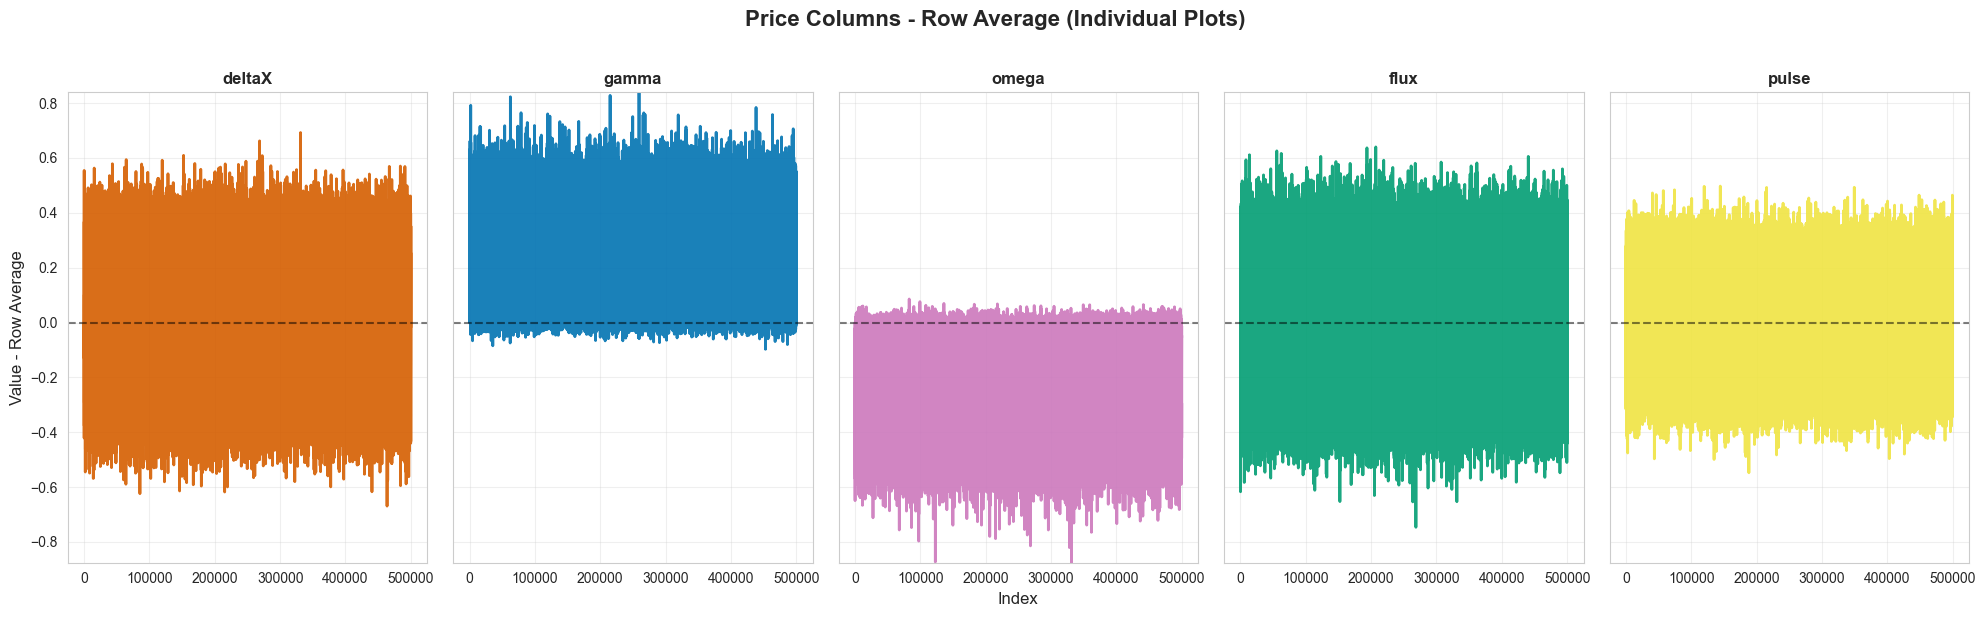

In [12]:
# Centering the price columns around their row averages (Possible due to assumption of similar open/close or high/low values explain previously)
row_averages = df_price_columns.mean(axis=1)
df_centered = df_price_columns.subtract(row_averages, axis=0)

# Plotting
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True, sharex=True)

# Get the overall y-range for consistent scaling
y_min = df_centered.min().min()
y_max = df_centered.max().max()

# Plot each column in a separate subplot
for i, column in enumerate(df_centered.columns):
    axes[i].plot(df_centered.index, df_centered[column], color=colors[i], linewidth=2, alpha=0.9)
    axes[i].set_title(f'{column}', fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[i].set_ylim(y_min, y_max)
    
    # Add x-label only to the middle subplot
    if i == 2:
        axes[i].set_xlabel('Index', fontsize=12)

axes[0].set_ylabel('Value - Row Average', fontsize=12)
fig.suptitle('Price Columns - Row Average (Individual Plots)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

#### Observations:
> From the deviation plots above, we can clearly observe that **`gamma`** consistently occupies the **uppermost band** while **`omega`** consistently remains in the **lowermost band** across all time periods. The y-axis ranges have been kept identical across all subplots to ensure accurate visual comparison without any scaling bias. This consistent positioning strongly indicates that **`gamma` represents the `High` price** and **`omega` represents the `Low` price** for each trading day.

### To validate the min and max columns we do the following analysis

In [13]:
max_cols = df_price_columns.idxmax(axis=1)
min_cols = df_price_columns.idxmin(axis=1)

max_counts = max_cols.value_counts()
min_counts = min_cols.value_counts()
row_counts = df_price_columns.count()

table = PrettyTable()
table.field_names = ["Column", "Max Count", "Min Count"]

for col in price_columns:
    max_count = max_counts.get(col, 0)
    min_count = min_counts.get(col, 0)
    table.add_row([col, max_count, min_count])

print(table)

+--------+-----------+-----------+
| Column | Max Count | Min Count |
+--------+-----------+-----------+
| deltaX |     0     |     0     |
| gamma  |   432559  |     0     |
| omega  |     0     |   432906  |
|  flux  |     0     |     0     |
| pulse  |   67441   |   67094   |
+--------+-----------+-----------+


#### Observations
> We can see that most of the rows' max value exist in the column `gamma` and most of the min values lies in column `omega`

<span style="color:green"><b><i> Hence we predict `gamma` to be the `High` price column. </b></i></span>

<span style="color:green"><b><i> And `omega` to be the `Low` price column. </b></i></span>

In [14]:
# Defining global variable for High and Low
HIGH = 'gamma'
LOW = 'omega'

### Row-wise Analysis for Identifying Price Column

#### A.6 Price represents the average price of the stock for the day

Now to distinguish between **Open**, **Close**, and **Price** within the columns `deltaX`, `flux`, and `pulse`, we apply the financial principle that the **Price** should logically fall between the **Open** and **Close** values for any given trading day. 

Since there is no specific definition of the `Price` column provided in our dataset, <span style="color:yellow">we assume that `Price` represents the **average price** of the stock for the day</span>. 

Using this assumption, we can establish the relationship: **Open ≤ Price ≤ Close** (when Bullish market) or **Close ≤ Price ≤ Open** (when Bearish market).

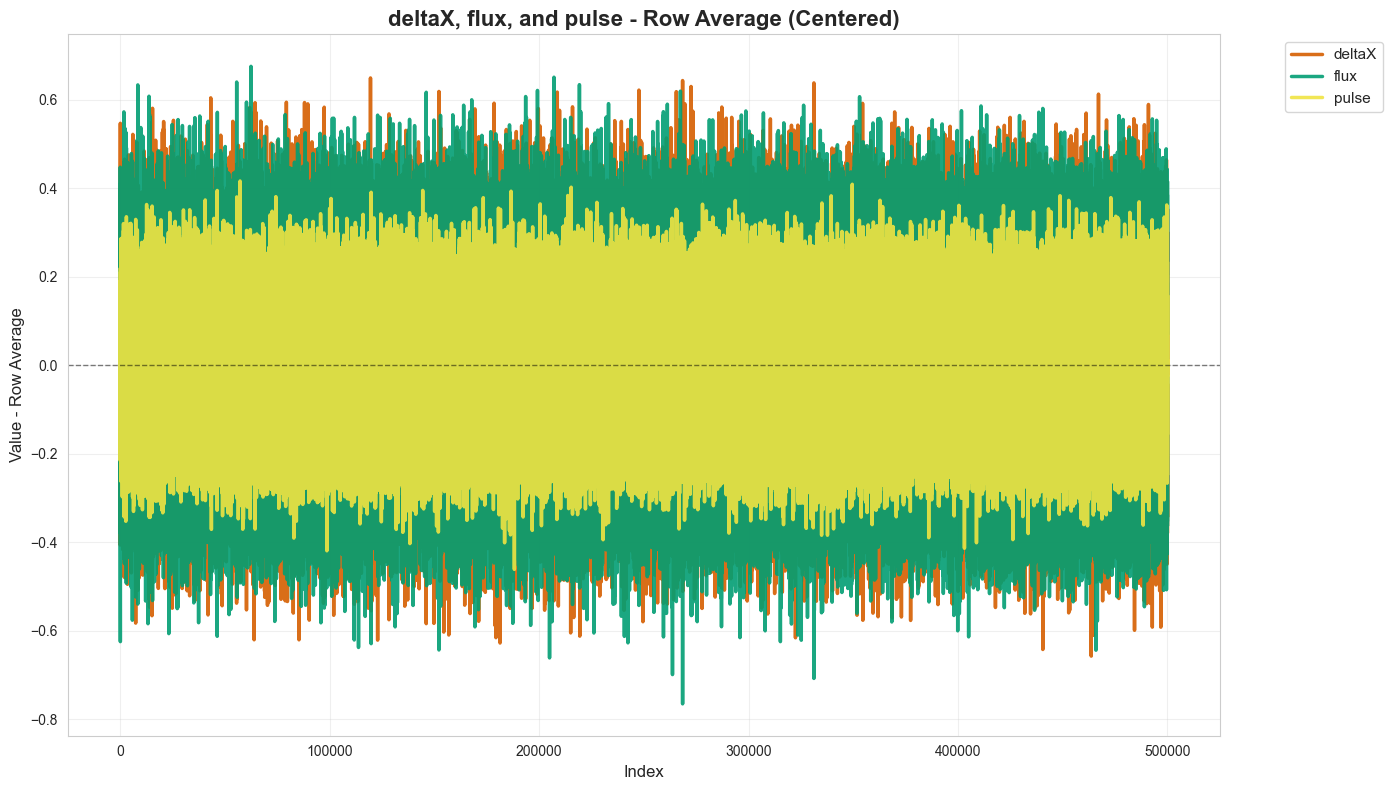

In [15]:
selected_columns = df[['deltaX', 'flux', 'pulse']]
row_averages_selected = selected_columns.mean(axis=1)
df_selected_centered = selected_columns.subtract(row_averages_selected, axis=0)

# Now we plot the line graph which has been centred
plt.figure(figsize=(14, 8))

selected_colors = [ORANGE, GREEN, YELLOW]

for i, column in enumerate(df_selected_centered.columns):
    plt.plot(df_selected_centered.index, df_selected_centered[column], label=column, linewidth=2.5, alpha=0.9, color=selected_colors[i])

plt.title('deltaX, flux, and pulse - Row Average (Centered)', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value - Row Average', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.tight_layout()
plt.show()

> We can clearly see that pulse lies in between the other two columns.

<span style="color:green"><b><i> Hence we predict `pulse` to be the original `Price` column. </b></i></span>

In [16]:
# Defining global variable for Price
PRICE = 'pulse'

#### A.7 Consecutive Rows = Sequential Data Points

To validate our assumption that the dataset represents consecutive trading days (i.e., <span style="color:yellow">each row represents data for the day following the previous row</span>), we examine inter-row correlation patterns. If this assumption holds true, stock prices should exhibit minimal variations between consecutive trading days, creating a relationship where price[t] ≈ price[t+1]. By plotting price[t] versus price[t+1], we expect to observe a strong linear relationship approximating the line y = x, which would confirm the sequential nature of our data.

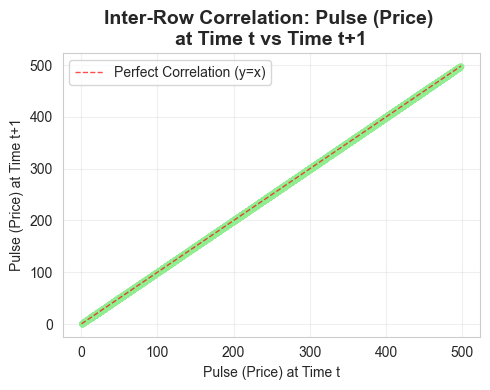

Correlation coefficient between pulse(t) and pulse(t+1): 1.0000


In [17]:
# X-axis: pulse value at time t
# Y-axis: pulse value at time t+1

# Get pulse values for current row (t) and next row (t+1)
pulse_t = df['pulse'][:-1].values        # All rows except the last one
pulse_t_plus_1 = df['pulse'][1:].values  # All rows except the first one

# Scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(pulse_t, pulse_t_plus_1, alpha=0.6, s=10, color='lightgreen')

plt.title('Inter-Row Correlation: Pulse (Price) \nat Time t vs Time t+1', fontsize=14, fontweight='bold')
plt.xlabel('Pulse (Price) at Time t', fontsize=10)
plt.ylabel('Pulse (Price) at Time t+1', fontsize=10)
plt.grid(True, alpha=0.3)

# Line to depict perfect correlation (x = y)
min_val = min(pulse_t.min(), pulse_t_plus_1.min())
max_val = max(pulse_t.max(), pulse_t_plus_1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=1, label='Perfect Correlation (y=x)')

plt.legend()
plt.tight_layout()
plt.show()

# Calculate and display correlation coefficient
correlation = np.corrcoef(pulse_t, pulse_t_plus_1)[0, 1]
print(f"Correlation coefficient between pulse(t) and pulse(t+1): {correlation:.4f}")

Observations:
> We observe a straight line with the coefficiet between pulse(t) and pulse(t+1) as 1. Thus,

<span style="color:yellow"><b> Our assumption of data being in order is satisfied. </b></span>

### Identification of the Open/ Close Fields :

It is generally known that closing price of the previous day is close/nearby opening price of the current day (cosecutive trading days), 

We will check the data for this trends to identify Open/Close from the deltaX/flux fields.

+--------+--------------------------------------+--------------------------+
|  Case  |                Metric                | Mean Absolute Difference |
+--------+--------------------------------------+--------------------------+
| Case 1 | Overnight Gap (Open[t+1] - Close[t]) |          0.4590          |
| Case 1 | Intraday Change (Close[t] - Open[t]) |          0.2256          |
| Case 2 | Overnight Gap (col2[t+1] - col1[t])  |          0.4587          |
| Case 2 | Intraday Change (col1[t] - col2[t])  |          0.2256          |
+--------+--------------------------------------+--------------------------+


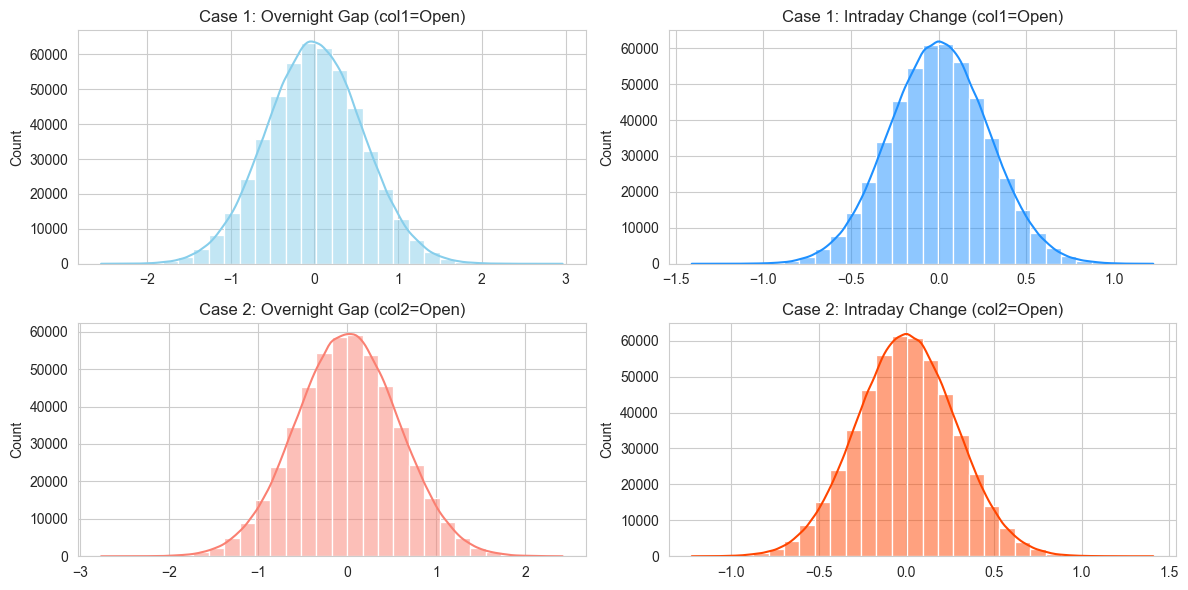

In [18]:
# CASE 1: col1 = Open, col2 = Close
overnight_gap_1 = df['deltaX'].shift(-1) - df['flux']
intraday_change_1 = df['flux'] - df['deltaX']

# CASE 2: col1 = Close, col2 = Open
overnight_gap_2 = df['flux'].shift(-1) - df['deltaX']
intraday_change_2 = df['deltaX'] - df['flux']

# Prepare PrettyTable for mean absolute differences
table = PrettyTable()
table.field_names = ["Case", "Metric", "Mean Absolute Difference"]

table.add_row(["Case 1", "Overnight Gap (Open[t+1] - Close[t])", f"{overnight_gap_1.abs().mean():.4f}"])
table.add_row(["Case 1", "Intraday Change (Close[t] - Open[t])", f"{intraday_change_1.abs().mean():.4f}"])
table.add_row(["Case 2", "Overnight Gap (col2[t+1] - col1[t])", f"{overnight_gap_2.abs().mean():.4f}"])
table.add_row(["Case 2", "Intraday Change (col1[t] - col2[t])", f"{intraday_change_2.abs().mean():.4f}"])

print(table)

# Plotting the distributions of overnight gaps and intraday changes for both cases
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(overnight_gap_1.dropna(), bins=30, kde=True, color='skyblue')
plt.title("Case 1: Overnight Gap (col1=Open)")

plt.subplot(2, 2, 2)
sns.histplot(intraday_change_1.dropna(), bins=30, kde=True, color='dodgerblue')
plt.title("Case 1: Intraday Change (col1=Open)")

plt.subplot(2, 2, 3)
sns.histplot(overnight_gap_2.dropna(), bins=30, kde=True, color='salmon')
plt.title("Case 2: Overnight Gap (col2=Open)")

plt.subplot(2, 2, 4)
sns.histplot(intraday_change_2.dropna(), bins=30, kde=True, color='orangered')
plt.title("Case 2: Intraday Change (col2=Open)")

plt.tight_layout()
plt.show()


#### Observation

> The **histograms** show that both **overnight gaps** and **intraday changes** follow a near-normal distribution centered around zero — meaning prices don’t consistently rise or fall; they fluctuate randomly.

### Candlestick Visual from Mapped Fields

> <span style="color:yellow">For grouping the days by month/year I have used the standard **252 trading days in an year** and **21 trading days in a month** on an average.</span>

#### <span style="color:cyan">Note: You can change the view of the candle stick plot to be <u>daily, monthly or yearly views</u>. Change the value of variables in the following cell to obtain the desired view.</span>

In [19]:
num_periods = 70        # Number of periods to display
period_type = "months"  # Type of period (days, months, years)

In [20]:
# CASE 1
sample_df_1 = pd.DataFrame({
    'open': df['deltaX'],
    'close': df['flux'],
    'high': df[HIGH],
    'low': df[LOW],
})

# CASE 2
sample_df_2 = pd.DataFrame({
    'open': df['flux'],
    'close': df['deltaX'],
    'high': df[HIGH],
    'low': df[LOW],
})

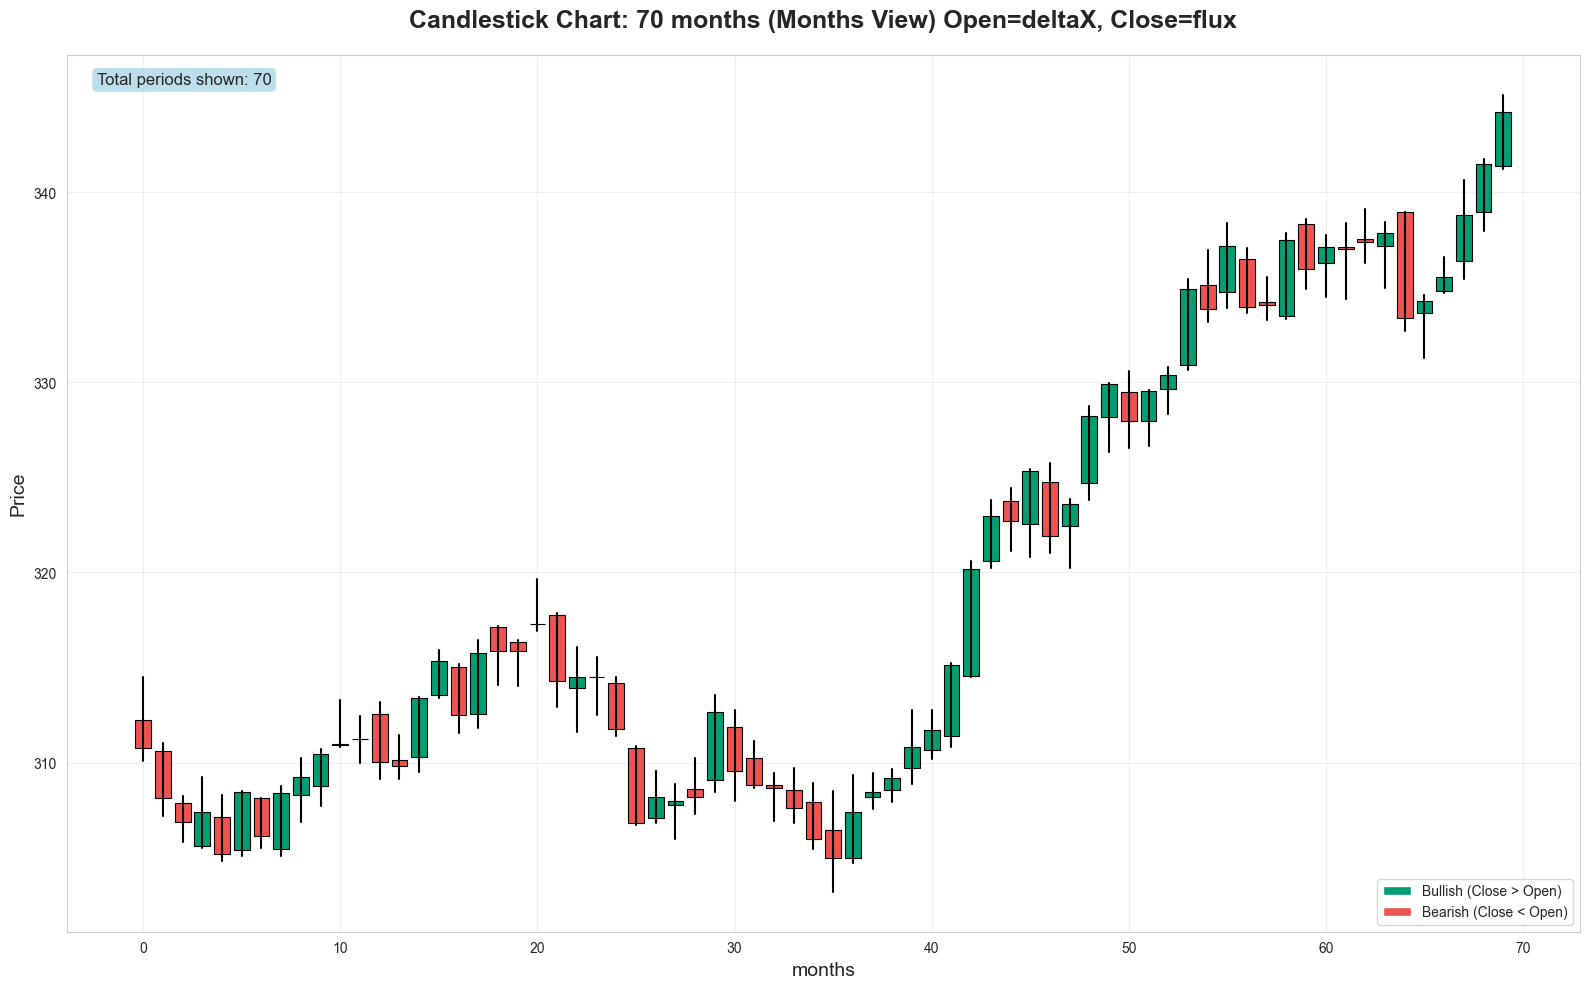

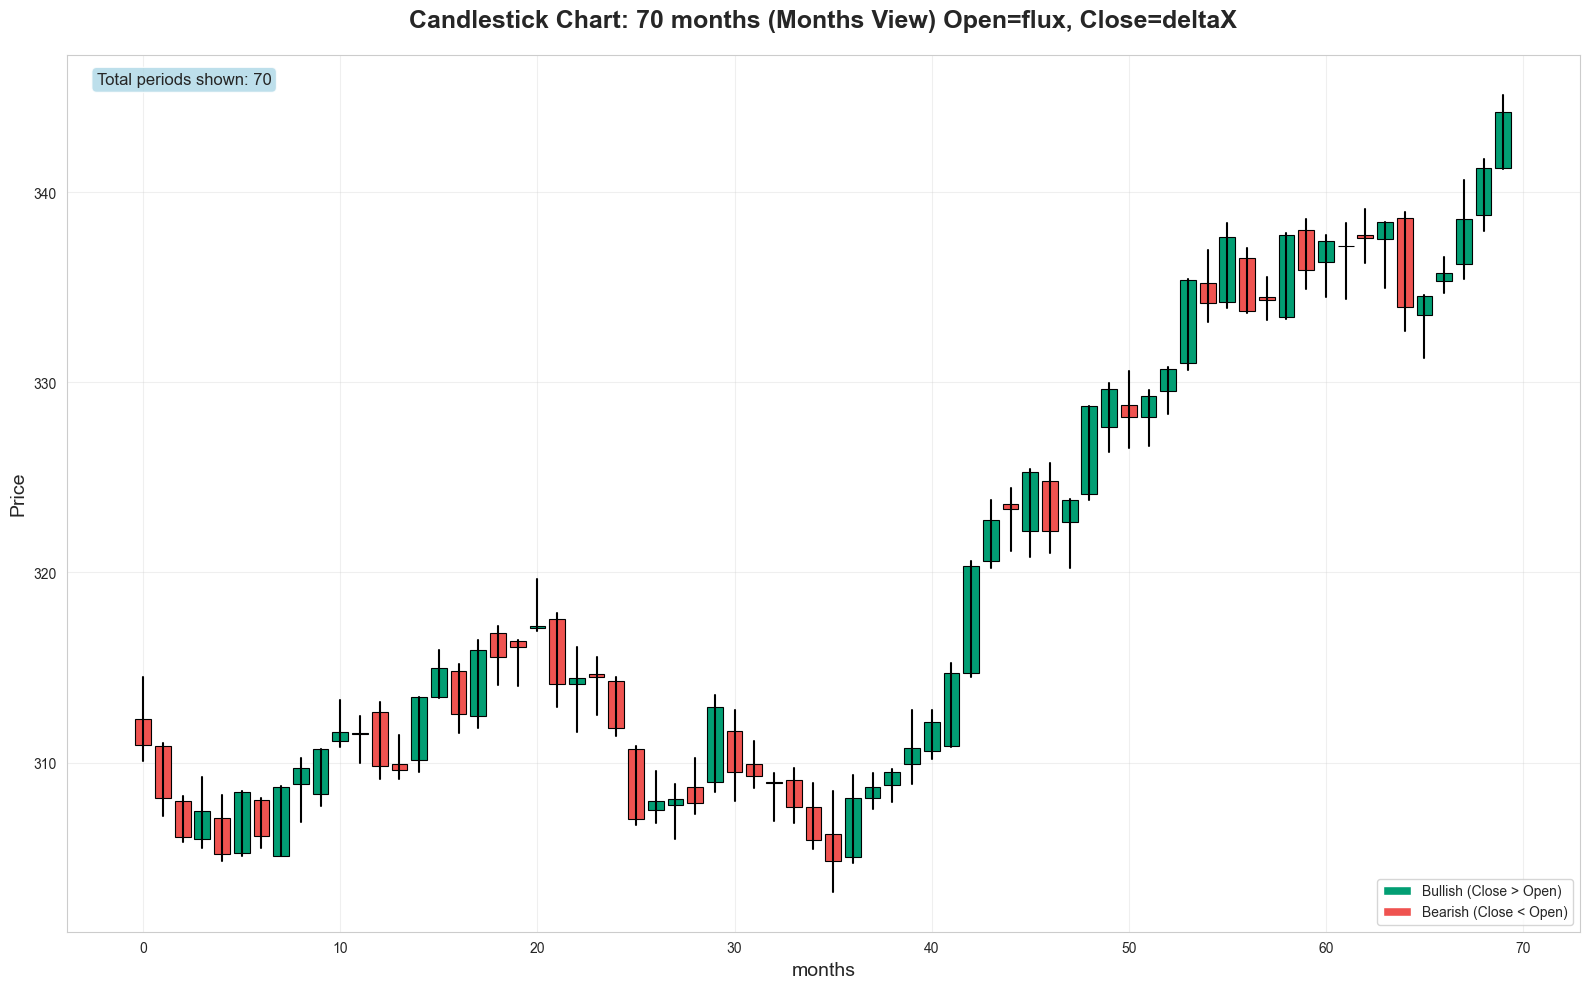

In [21]:
def aggregate_data(data, period_type, num_periods):
    if period_type == 'days':
        # No aggregation needed, just slice the data
        return data.head(num_periods)
    
    elif period_type == 'months':
        # Group every 21 days
        days_per_period = 21
        num_rows_needed = num_periods * days_per_period
        data_subset = data.head(num_rows_needed)
        
        aggregated_data = []
        for i in range(0, len(data_subset), days_per_period):
            period_data = data_subset.iloc[i:i+days_per_period]
            if len(period_data) > 0:
                agg_row = {
                    'open': period_data['open'].iloc[0],      # First day's open
                    'close': period_data['close'].iloc[-1],   # Last day's close
                    'high': period_data['high'].max(),        # Highest high
                    'low': period_data['low'].min(),          # Lowest low
                }
                aggregated_data.append(agg_row)
        
        return pd.DataFrame(aggregated_data)
    
    elif period_type == 'years':
        # Group every 252 days
        days_per_period = 252
        num_rows_needed = num_periods * days_per_period
        data_subset = data.head(num_rows_needed)
        
        aggregated_data = []
        for i in range(0, len(data_subset), days_per_period):
            period_data = data_subset.iloc[i:i+days_per_period]
            if len(period_data) > 0:
                # OHLC aggregation logic
                agg_row = {
                    'open': period_data['open'].iloc[0],      # First day's open
                    'close': period_data['close'].iloc[-1],   # Last day's close
                    'high': period_data['high'].max(),        # Highest high
                    'low': period_data['low'].min(),          # Lowest low
                }
                aggregated_data.append(agg_row)
        
        return pd.DataFrame(aggregated_data)

def plot_candlestick(data, period_type='days', num_periods=50, subtitle=''):
    plot_data = aggregate_data(data, period_type, num_periods)
    
    _, ax = plt.subplots(figsize=(16, 10))
    
    for i, (_, row) in enumerate(plot_data.iterrows()):
        open_price = row['open']
        close_price = row['close']
        high_price = row['high'] 
        low_price = row['low']
        
        color = GREEN if close_price >= open_price else RED
        
        ax.plot([i, i], [low_price, high_price], color='black', linewidth=1.5)
        
        # Draw the body rectangle
        body_height = abs(close_price - open_price)
        body_bottom = min(open_price, close_price)
        
        rect = Rectangle((i-0.4, body_bottom), 0.8, body_height, facecolor=color, edgecolor='black', linewidth=0.8)
        ax.add_patch(rect)
    
    # Set title based on period type
    title = f'Candlestick Chart: {num_periods} {period_type} ({period_type.capitalize()} View) {subtitle}'
    
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel(f'{period_type}', fontsize=14)
    ax.set_ylabel('Price', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add legend
    green_patch = Rectangle((0, 0), 1, 1, facecolor=GREEN, label='Bullish (Close > Open)')
    red_patch = Rectangle((0, 0), 1, 1, facecolor=RED, label='Bearish (Close < Open)')
    ax.legend(handles=[green_patch, red_patch], loc='lower right')
    
    ax.text(0.02, 0.98, f'Total periods shown: {len(plot_data)}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Add date index for candlestick plotting
sample_df_1.index = range(len(sample_df_1))
plot_candlestick(sample_df_1, period_type, num_periods, "Open=deltaX, Close=flux")

# Add date index for candlestick plotting
sample_df_2.index = range(len(sample_df_2))
plot_candlestick(sample_df_2, period_type, num_periods, "Open=flux, Close=deltaX")

<span style="color:green">This confirms the structural pattern of price movement and supports the inferred mapping.</span>

> From the above candle stick diagrams it is not directly apparent as in which one seems to be a more correct. To quantify it we will calculate the average fluctuation between closing price of last month and opening price of next month. Generally both of them should be close enough so whichever has a smaller value of the average distance we will go ahead with that in assignment.

Period Type: months, Number of Periods: 70
+-------------+-------------------------+-----------------------------+
|   Mapping   |      Configuration      | Mean Absolute Overnight Gap |
+-------------+-------------------------+-----------------------------+
|    Sample   | deltaX=Open, flux=Close |            0.4601           |
| Alternative | flux=Open, deltaX=Close |            0.4439           |
+-------------+-------------------------+-----------------------------+



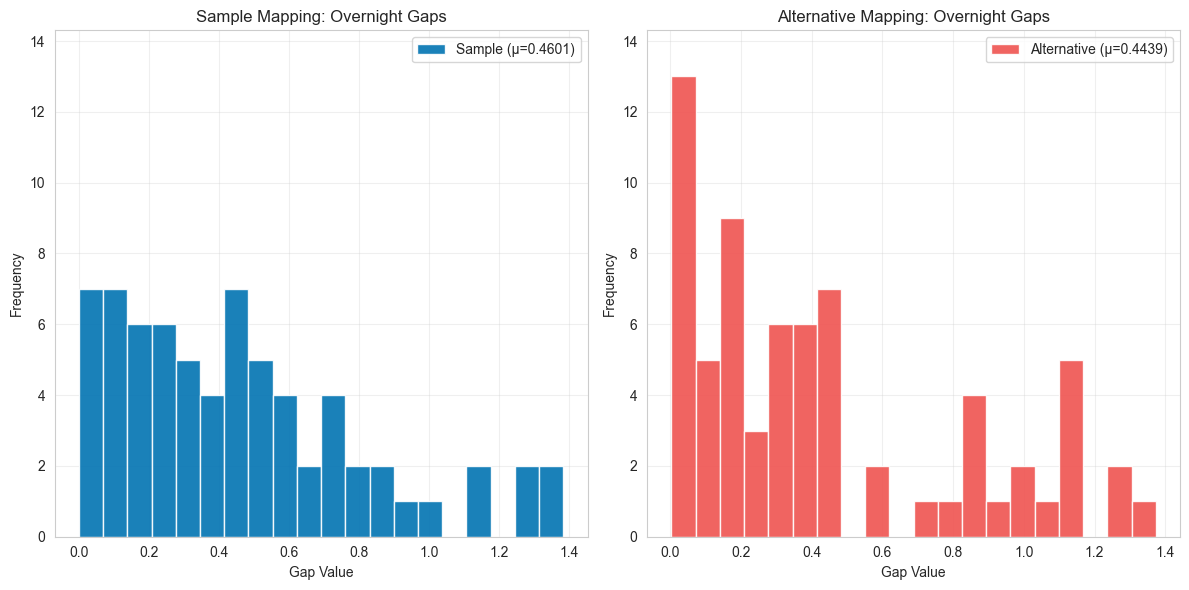

In [35]:
def calculate_overnight_gap(data, period_type, num_periods):
    aggregated_data = aggregate_data(data, period_type, num_periods)
    
    # Calculate overnight gaps: opening[t] - closing[t-1]
    overnight_gaps = []
    for i in range(1, len(aggregated_data)):
        close_prev = aggregated_data.iloc[i-1]['close']
        open_curr = aggregated_data.iloc[i]['open']
        gap = open_curr - close_prev
        overnight_gaps.append(gap)
    
    return np.mean(np.abs(overnight_gaps))

# Calculate overnight gaps for both mappings
sample_1_gap = calculate_overnight_gap(sample_df_1, period_type, num_periods)
sample_2_gap = calculate_overnight_gap(sample_df_2, period_type, num_periods)

# Create PrettyTable for results
results_table = PrettyTable()
results_table.field_names = ["Mapping", "Configuration", "Mean Absolute Overnight Gap"]
results_table.add_row(["Sample", "deltaX=Open, flux=Close", f"{sample_1_gap:.4f}"])
results_table.add_row(["Alternative", "flux=Open, deltaX=Close", f"{sample_2_gap:.4f}"])

print(f"Period Type: {period_type}, Number of Periods: {num_periods}")
print(results_table)
print()
    
# Get aggregated data for both mappings
sample_1_agg = aggregate_data(sample_df_1, period_type, num_periods)
sample_2_agg = aggregate_data(sample_df_2, period_type, num_periods)

# Calculate individual gaps for sample_1
sample_1_gaps = []
for i in range(1, len(sample_1_agg)):
    gap = sample_1_agg.iloc[i]['open'] - sample_1_agg.iloc[i-1]['close']
    sample_1_gaps.append(abs(gap))

# Calculate individual gaps for sample_2
sample_2_gaps = []
for i in range(1, len(sample_2_agg)):
    gap = sample_2_agg.iloc[i]['open'] - sample_2_agg.iloc[i-1]['close']
    sample_2_gaps.append(abs(gap))

# Calculate histogram data to compute y_max before plotting
hist_1, _ = np.histogram(sample_1_gaps, bins=20)
hist_2, _ = np.histogram(sample_2_gaps, bins=20)
y_max = max(hist_1.max(), hist_2.max())

# Plot comparison with same y-scale
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sample_1_gaps, bins=20, alpha=0.9, color=BLUE, label=f'Sample (μ={np.mean(np.abs(sample_1_gaps)):.4f})')
plt.title('Sample Mapping: Overnight Gaps')
plt.xlabel('Gap Value')
plt.ylabel('Frequency')
plt.ylim(0, y_max * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(sample_2_gaps, bins=20, alpha=0.9, color=RED, label=f'Alternative (μ={np.mean(np.abs(sample_2_gaps)):.4f})')
plt.title('Alternative Mapping: Overnight Gaps')
plt.xlabel('Gap Value')
plt.ylabel('Frequency')
plt.ylim(0, y_max * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Observations

> As we can see that the sample_2 mapping has most of the frequency in the lower range and on an average less gaps between overnight changes, we consider flux = Open, deltaX = Close

<span style="color:green"><b><i> Hence we predict `deltaX` to be the `Close` price column. </b></i></span>

<span style="color:green"><b><i> And `flux` to be the `Open` price column. </b></i></span>

In [23]:
# Defining global variable for Open and Close
OPEN = 'flux'
CLOSE = 'deltaX'

## Calculating Confidences

### Confidence for `neutronCount` = `Volume`
Since the value of volume is always an integer, we calculate confidence based on the fraction of integer values out of all values for the column

In [24]:
volume_int_count = df[VOLUME].apply(lambda x: isinstance(x, int))
confidence_vol = volume_int_count.mean()
print(f"Confidence that neutronCount represents Volume: {confidence_vol}")

Confidence that neutronCount represents Volume: 1.0


### Confidence that `gamma` = `High`
Since the value of high for each data point should be highest (excluding volume) among low, high, open, close and price data we calculate the confidence as the fraction of rows where `gamma` is indeed the highest value among `deltaX`, `gamma`, `omega`, `pulse` and `flux`

In [25]:
high_max_count = (df_price_columns.idxmax(axis=1) == HIGH).sum()
confidence_high = high_max_count / len(df_price_columns)
print(f"Confidence that gamma represents High: {confidence_high:.3f}")

Confidence that gamma represents High: 0.865


### Confidence that `omega` = `Low`
Similar to the logic for `gamma` being the high we calculate the fraction of rows in which `omega` has the lowest value among the columns `deltaX`, `gamma`, `omega`, `pulse` and `flux`

In [26]:
low_min_count = (df_price_columns.idxmin(axis=1) == LOW).sum()
confidence_low = low_min_count / len(df_price_columns)
print(f"Confidence that omega represents Low: {confidence_low:.3f}")

Confidence that omega represents Low: 0.866


### Confidence that `pulse` = `Price`
Since we have assumed that `price` is the average [A.6] value of stock for the day, we calculate the confidence for price by computing the expected average for each day as the mean of `High`, `Low`, `Open` and `Close` values and calculating the absolute average deviation of this expected average from the value of `pulse`. Note that when the day's trading range (high - low) is very small, even small differences between predicted and estimated values should be penalized more heavily, so we have scaled the deviation accordingly by the daily range.

In [27]:
Open = df[OPEN]
Close = df[CLOSE]
High = df[HIGH]
Low = df[LOW]
pulse = df[PRICE]

expected_avg = (Open + Close + High + Low) / 4
daily_range = High - Low

# Absolute deviation between expected average and the pulse value
abs_deviation = abs(pulse - expected_avg)

# Scaling to account for varying daily ranges
scaled_deviation = abs_deviation / (daily_range + EPSILON)
confidence = 1 - scaled_deviation.clip(upper=1).mean()

print(f"Confidence that pulse represents Price: {round(confidence, 3)}")

Confidence that pulse represents Price: 0.647


### Confidence that `flux` = `Open` and `deltaX` = `Close`


Since we have very high confidence in high-low measure, we will estimate how well the **open-to-close (O–C)** return aligns with the theoretically more efficient **Parkinson high-low-based** volatility estimator. This can be translated into a **"confidence score"** as a ratio of how close the open-close volatility estimate is to the high-low one.

This confidence measure works by comparing the open-close volatility estimate, which is often noisy, to the Parkinson volatility estimate based on high-low prices, which captures more of the true intraday movement. Since the Parkinson model is statistically more efficient, a close match indicates that the open and close values align well with actual price behavior, implying high confidence. A large deviation suggests inconsistencies or missing information in the open-close data, leading to lower confidence.

1. **Parkinson (high-low)**:

   $$
   \hat{\sigma}_p = \sqrt{252} \cdot \ln\left(\frac{H_t}{L_t}\right) \cdot \sqrt{\frac{\pi}{8}}
   $$

2. **Open-Close**:

   $$
   \hat{\sigma}_{oc} = \sqrt{252} \cdot \left| \ln\left(\frac{C_t}{O_t} \right) \right| \cdot \sqrt{\frac{\pi}{2}}
   $$

You can then define a **confidence score** as:

$$
\text{Confidence}_t = 1 - \left| \frac{\hat{\sigma}_{oc, t} - \hat{\sigma}_{p, t}}{\hat{\sigma}_{p, t}} \right|
$$

This score:

* Equals **1** when both volatility estimates match (perfect confidence),
* Decreases as the deviation between O–C and H–L based volatility increases.

##### References:

* [Parkinson Volatility Model: Simulation Analysis | by Tanapon Chamnankarnkar, FRM | Medium](https://share.google/BH9YnKarRI2lkjp7D)


In [28]:
ln_HL = np.log(High / Low)
ln_CO = np.abs(np.log(Close / Open))

vol_p = (252**0.5) * ln_HL * (np.pi / 8)**0.5
vol_oc = (252**0.5) * ln_CO * (np.pi / 2)**0.5

# Compute confidence
confidence_open_close = 1 - np.abs(vol_oc - vol_p) / vol_p
confidence_open_close = np.clip(confidence_open_close, 0, 1)

print(f"Mean Confidence Score: {round(confidence_open_close.mean(), 3)}")

Mean Confidence Score: 0.6



Since the **OC confidence is derived using High and Low as ground truth**, the overall confidence should also include how reliable H and L are.

$$
\text{Overall OC Confidence} = \text{OC Confidence} \times \text{H Confidence} \times \text{L Confidence}
$$

$$
= 0.60 \times 0.865 \times 0.866 = 0.449
$$

Assuming that flux = open has the same confidence as deltaX = close

$$
\therefore x^{2} = 0.449
$$
where $x$ is the confidence score for flux = open and deltaX = close each. 
$$
\therefore x = 0.67
$$

## The final candle-stick diagram

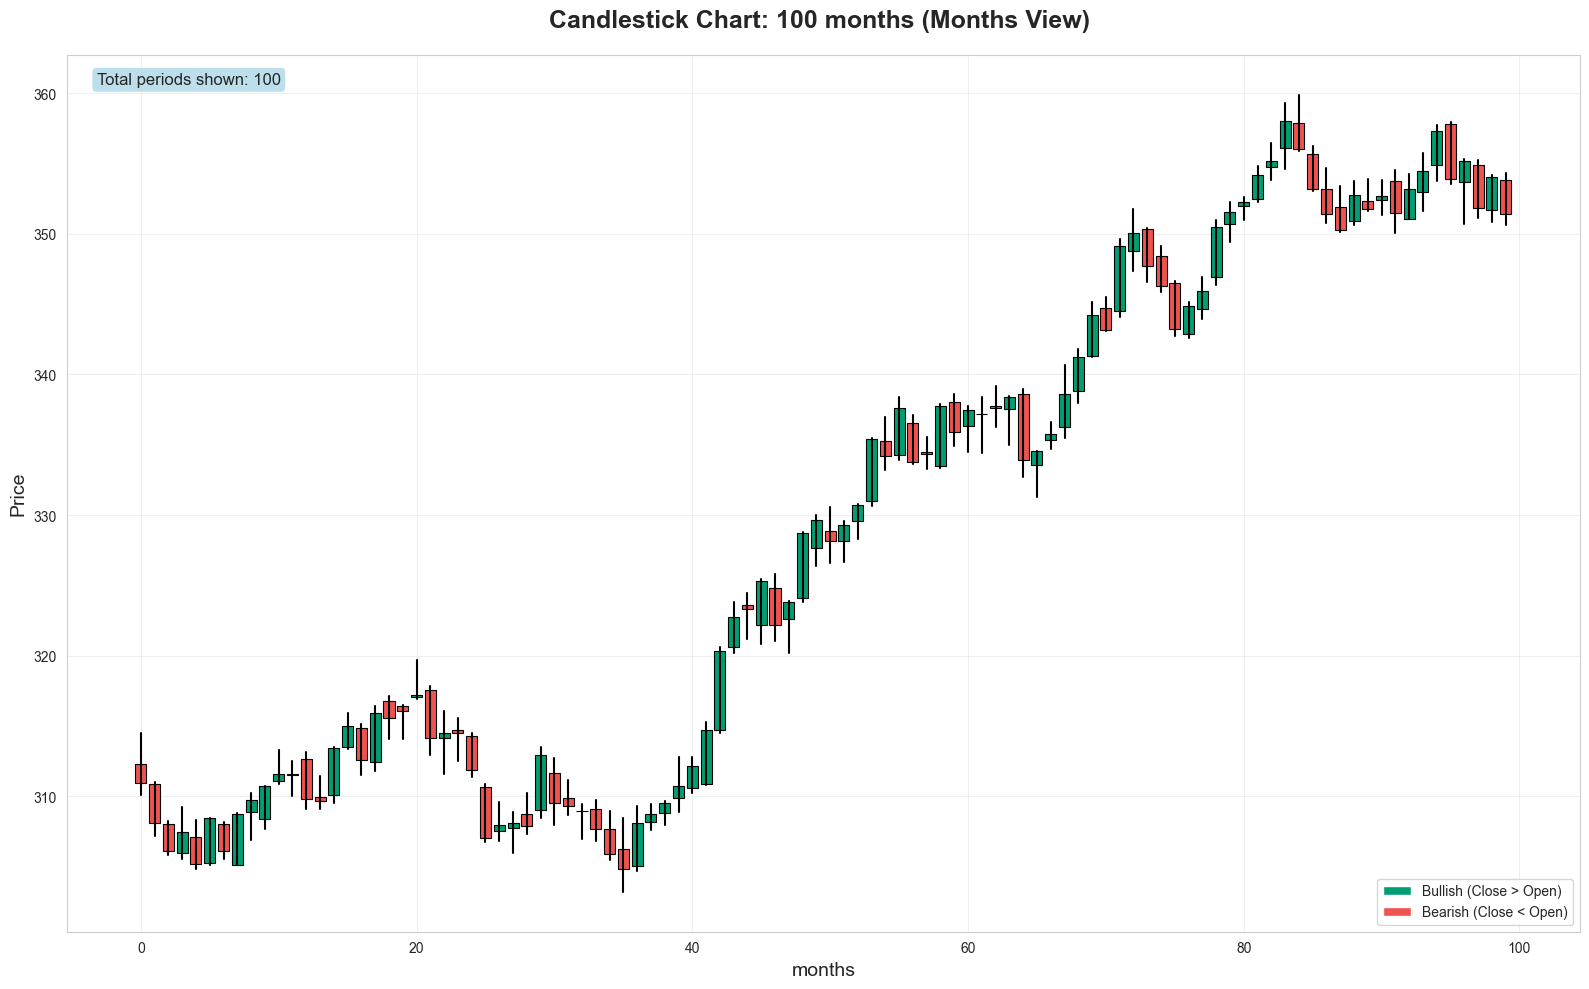

In [29]:
plot_candlestick(sample_df_2, "months", 100)